In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('input/Customers_in_a_Shop.csv',header=None)
data.columns = ['Date','Customers']
data['Date'] = pd.to_datetime(data['Date'],format="%Y-%m")
data = data.set_index('Date')
data.shape

(144, 1)

# Missing Values

我們有以下方法來處理時間序列數據中的缺失值。
- (1) Mean Imputation 均值插補
- (2) Last Observation Carried forward 最後一次觀察結轉
- (3) Seasonal Interpolation 季節性插值
- (4) Linear Interpolation 線性插值 (最常使用)

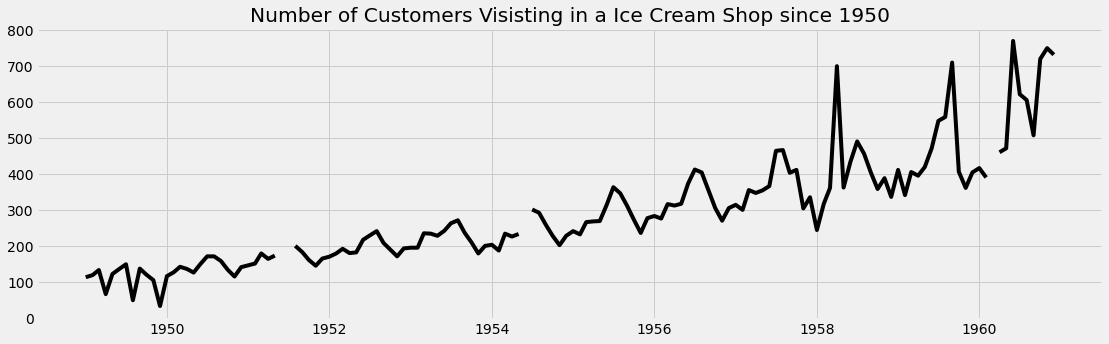

In [3]:
plt.rcParams['figure.figsize']=(17,5)
plt.plot(data,color='black')
plt.title("Number of Customers Visisting in a Ice Cream Shop since 1950")
plt.show()

## 1.Mean Imputation 均值插補

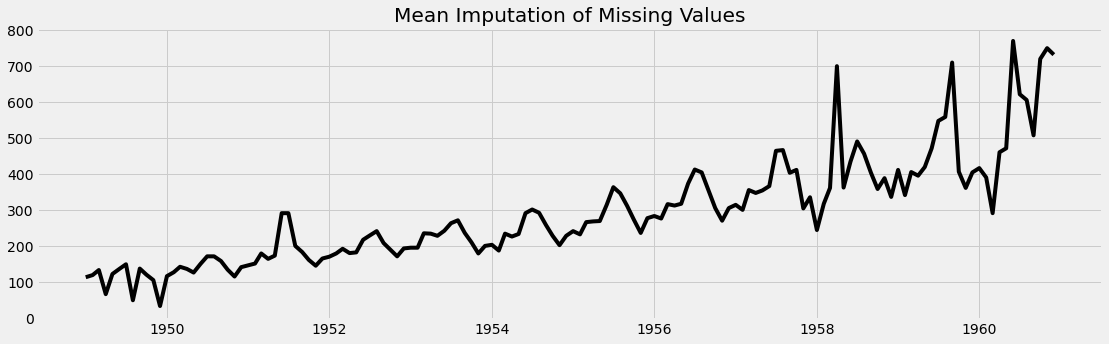

In [29]:
plt.rcParams['figure.figsize']=(17,5)
data['Customers_mean'] = data['Customers'].fillna(data['Customers'].mean())
plt.plot(data['Customers_mean'],color='black')
plt.title("Mean Imputation of Missing Values")
plt.show()

## 2. Last Observation Carried forward 最後一次觀察結轉

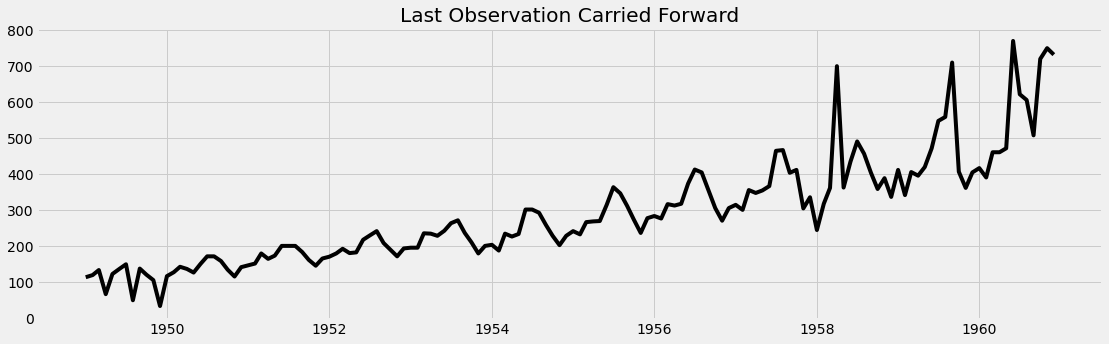

In [30]:
plt.rcParams['figure.figsize']=(17,5)
data['Customers_mean'] = data['Customers'].bfill()
plt.plot(data['Customers_mean'],color='black')
plt.title("Last Observation Carried Forward")
plt.show()

## 3.Seasonal Interpolation 季節性插值

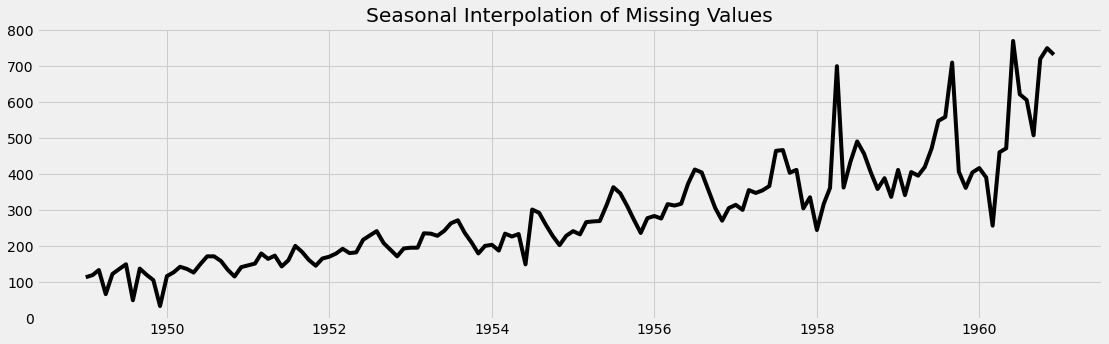

In [32]:
# lets find the dates where we have missing values
data.index[data['Customers'].isnull()]
data.loc['1960-03'].fillna((data['1949-03':'1959-03':12].sum())/data['1949-03':'1959-03':12].shape[0], inplace=True)
data.loc['1954-06'].fillna((data['1949-06':'1953-06':12].sum())/data['1949-06':'1953-06':12].shape[0], inplace=True)
data.loc['1951-07'].fillna((data['1949-07':'1950-07':12].sum())/data.loc['1949-07':'1950-07':12].shape[0], inplace=True)
data.loc['1951-06'].fillna((data['1949-06':'1950-06':12].sum())/data['1949-06':'1950-06':12].shape[0], inplace=True)

plt.rcParams['figure.figsize']=(17,5)
plt.plot(data['Customers'],color='black')
plt.title("Seasonal Interpolation of Missing Values")
plt.show()

## 4.Linear Interpolation 線性插值 (最常使用)

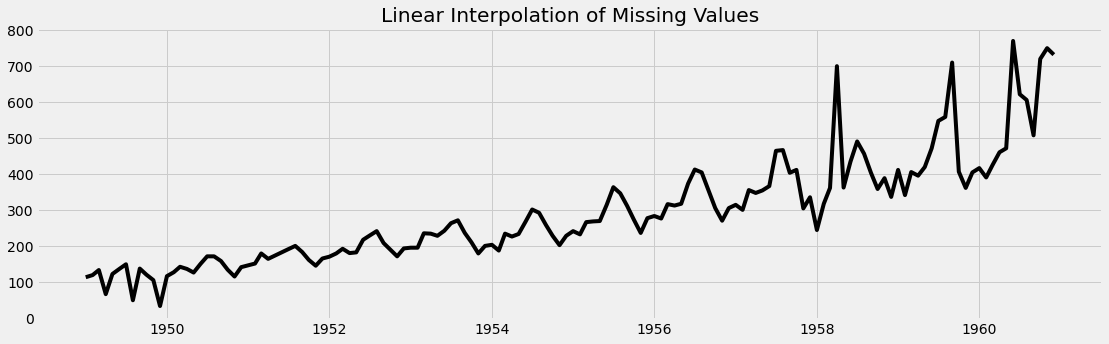

In [4]:
plt.rcParams['figure.figsize']=(17,5)
data['Customers_linear']=data['Customers'].interpolate(method='linear')
plt.plot(data['Customers_linear'],color='black')
plt.title("Linear Interpolation of Missing Values")
plt.show()

## --------------------------------------------------------

# Outliers 異常值偵測

## Stationarity 平穩性
平穩性意味著生成時間序列的過程的統計特性「不會隨時間變化」。 統計屬性是均值、方差和協方差，無論您觀察它們的時間如何，它們都是相同的。平穩性是一個重要的概念，因為平穩過程更容易分析和建模。

In [5]:
data['Customers_linear'].loc[(data['Customers_linear']>=700)] = 622
data.describe()

,Customers,Customers_linear
count,140.000000,144.000000
mean,291.878571,286.680556
std,150.040592,136.456487
min,34.000000,34.000000
25%,180.000000,180.750000
50%,265.500000,265.500000
75%,364.750000,364.750000
max,770.000000,622.000000


## Box plot 箱形圖
它是一種標準化的數據分佈顯示方式。 任何小於 Q1-1.5IQR 或大於 Q3+1.5IQR 的數據點都被視為異常值。

<AxesSubplot:xlabel='Customers_linear'>

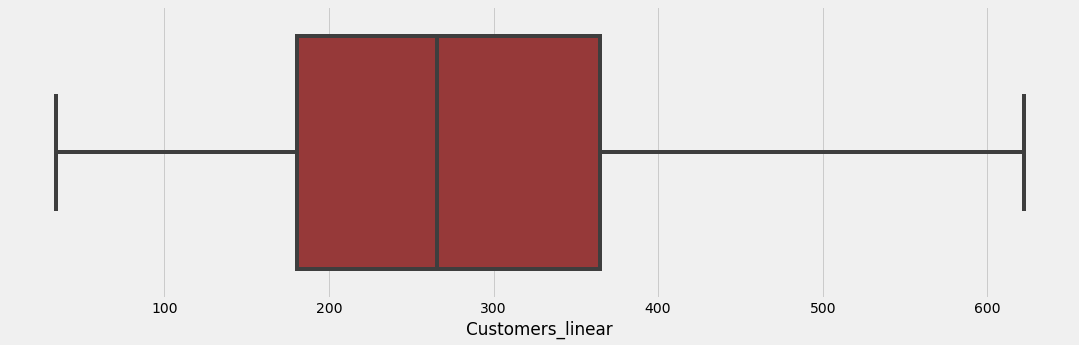

In [6]:
import seaborn as sns
plt.rcParams['figure.figsize']=(17,5)
sns.boxplot(data['Customers_linear'], color='brown')

In [7]:
data['Customers_linear'].sort_values(ascending = False).head(7)

Date
1960-12-01    622.0
1959-09-01    622.0
1960-10-01    622.0
1960-07-01    622.0
1960-06-01    622.0
1960-11-01    622.0
1958-04-01    622.0
Name: Customers_linear, dtype: float64

In [8]:
# outliers treatment

data['Customers_linear'].loc[(data['Customers_linear']>=700)] = 622
# lets also check the null values again
data.isnull().sum()

Customers           4
Customers_linear    0
dtype: int64

## Augmented Dickey–Fuller test 擴張DF檢定  (ADF) 

（ADF 檢驗）是一種常用的統計檢驗，用於檢驗給定的時間序列是否平穩。 在分析序列的平穩性時，它是最常用的統計檢驗之一。所得出之統計值必為負數，負越多越傾向於拒絕虛無假說。

- p-value > 0.05：未能拒絕原假設（H0），數據有單位根且非平穩。
- p-value <= 0.05：拒絕原假設（H0），數據沒有單位根並且是平穩的。

p 值為 1 且其值大於 0.05 ，因此無法拒絕原假設。 因此，數據具有單位根並且是非平穩的平均值不是平穩的。方差隨時間波動。

In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Customers_linear'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: 2.7105600112832855
n_lags: 0.9990875034273379
p-value: 0.9990875034273379
Critial Values:
   1%, -3.482087964046026
Critial Values:
   5%, -2.8842185101614626
Critial Values:
   10%, -2.578864381347275


## Kwiatkowski-Phillips-Schmidt-Shin 單根檢定（KPSS unit root test）

(KPSS) 檢驗確定時間序列是圍繞均值或線性趨勢平穩，還是由於單位根而非平穩。 平穩時間序列是統計屬性（如均值和方差）隨時間保持不變的時間序列。對於 KPSS 測試，

- 零假設(Null Hypothesis)：當 p 值 >0.05 時序列是平穩的
- 替代假設 (Alternate Hypothesis)：當 p 值 <= 0.5 時，序列不是平穩的

In [10]:
#loading kpss from statsmodel
from statsmodels.tsa.stattools import kpss

result = kpss(data['Customers_linear'])
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'num lags: {result[2]}')
print('Critial Values:')
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  


KPSS Statistic: 1.0654466813105485
p-value: 0.01
num lags: 14
Critial Values:
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\cti110016\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


## --------------------------------------------------------

# Non-Stationary to Stationary Series 非平穩轉換到平穩序列
有兩種工具可以將非平穩序列轉換為平穩序列。

- 1.Transformation 轉型
- 2.Differencing 差分

差分工具用於使時間序列的均值保持不變。 這意味著它從系列中刪除了趨勢。

差分意味著計算連續觀察之間的差異。 差分通過從序列中去除趨勢來穩定時間序列的均值。

## Box Cox Transformation 轉型
Box Cox Transformation 是一種將非正態因變量轉換為正態形狀的方法。 正態性是許多統計技術的重要假設； 如果您的數據不正常，應用 Box-Cox 意味著您可以運行更多的測試。

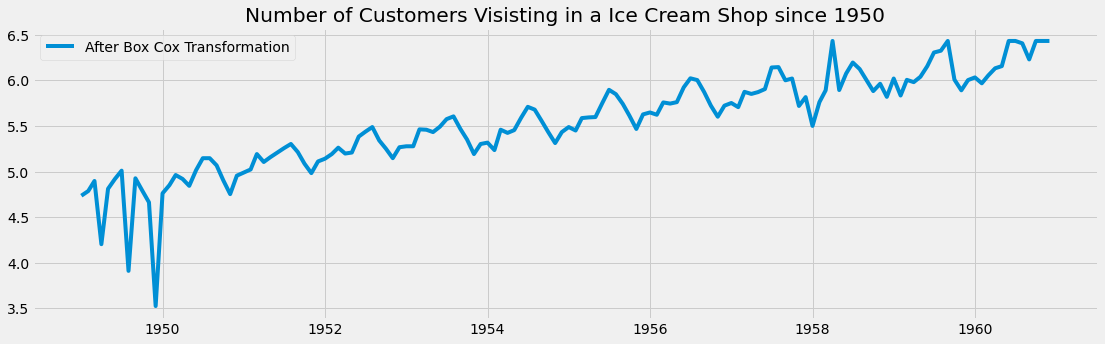

In [11]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Customers_linear'],lmbda=0),index=data.index)
plt.plot(data_boxcox, label="After Box Cox Transformation")
plt.legend()
plt.title("Number of Customers Visisting in a Ice Cream Shop since 1950")
plt.show()

## Differencing 差分

差分通過消除時間序列水平的變化來穩定時間序列的平均值，從而消除（或減少）趨勢和季節性。

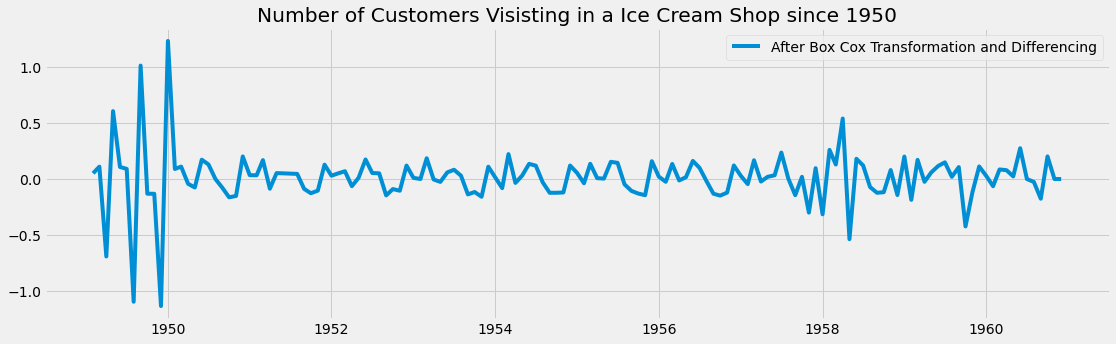

In [12]:
data_boxcox_difference= pd.Series(data_boxcox-data_boxcox.shift(), index=data.index)
data_boxcox_difference.dropna(inplace=True)
plt.plot(data_boxcox_difference, label="After Box Cox Transformation and Differencing")
plt.legend()
plt.title("Number of Customers Visisting in a Ice Cream Shop since 1950")
plt.show()

## --------------------------------------------------------

# Auto Correlation function 自相關函數

## Auto Correleation Function 自相關函數 (ACF)

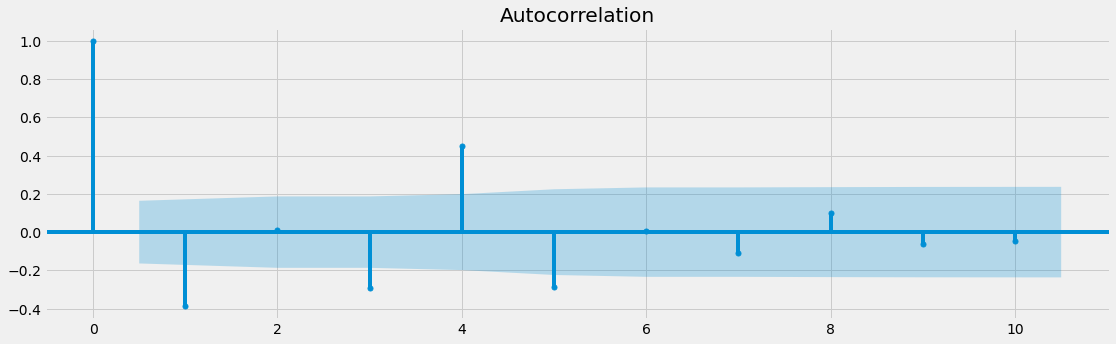

In [13]:
#Loading and plotting acf
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data_boxcox_difference, ax=plt.gca(), lags=10)
plt.show()

## Partial Auto Correleation Function 偏自相關函數 (PACF)
偏自相關函數 (PACF) 給出了平穩時間序列與其自身滯後值的偏相關，在所有較短的滯後處對時間序列的值進行回歸。它與不控制其他滯後的自相關函數形成對比。

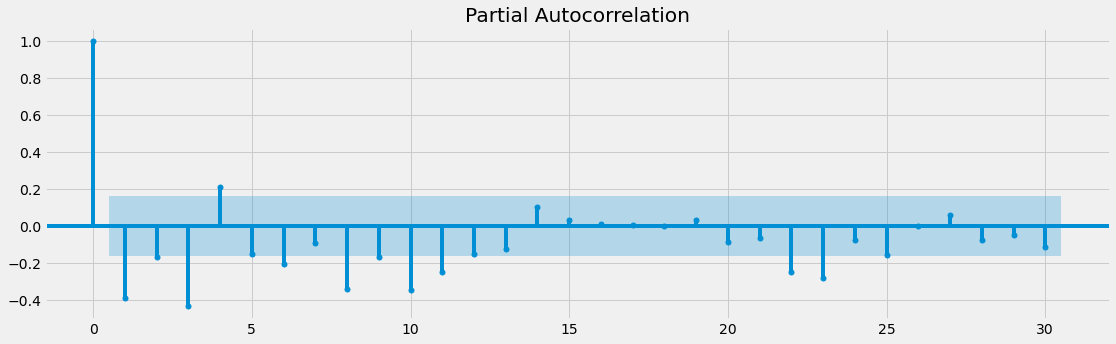

In [14]:
#Loading and plottin pacf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_boxcox_difference, ax=plt.gca(), lags=30)
plt.show()

## --------------------------------------------------------

# Splitting into Train and Test dataset 拆分訓練和測試集

In [15]:
length_train = 115
train = data.iloc[:length_train,:]
test=data.iloc[length_train:,:]

In [16]:
train_data_boxcox = data_boxcox[:length_train]
test_data_boxcox = data_boxcox[length_train:]
train_data_boxcox_difference = data_boxcox_difference[:length_train-1]
test_data_boxcox_difference = data_boxcox_difference[length_train-1:]  

## 1.AutoRegressive Model 自回歸模型 (AR)

統計上一種處理時間序列的方法，用同一變數例如 x 的之前各期，亦即 x1 至x(t-1) 來預測本期 x(t) 的表現，並假設它們為一線性關係。因為這是從線性迴歸發展而來，只是不用 x 預測 y，而是用 x 預測 x（自己）；所以叫做自迴歸。回歸模型將未來觀察預測為一個或多個過去觀察的線性回歸。
自迴歸模型被廣泛運用在經濟學、資訊學、自然現象的預測上。自回歸模型方程為

y(t) = β_0 + β_1 y(t-2) + β_2 y(t-4) + β_3 y(t-6)

In [17]:
from statsmodels.tsa.arima_model import ARIMA

model_ar = ARIMA(train_data_boxcox_difference, order=(1,0,0))
model_fit = model_ar.fit()
print(model_fit.params)

const      0.012440
ar.L1.y   -0.398536
dtype: float64


C:\Users\cti110016\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


### Recover Original Time Series

In [18]:
y_ar_new = data_boxcox_difference.copy()
y_ar_new['ar_forecast_boxcox_difference'] = model_fit.predict(data_boxcox_difference.index.min(),
                                                              data_boxcox_difference.index.max())
y_ar_new['ar_forecast_boxcox'] = y_ar_new['ar_forecast_boxcox_difference'].cumsum()
y_ar_new['ar_forecast_boxcox'] = y_ar_new['ar_forecast_boxcox'].add(data_boxcox[0])
y_ar_new['ar_forecast'] = np.exp(y_ar_new['ar_forecast_boxcox'])

### Plotting Train, Test and Forecast

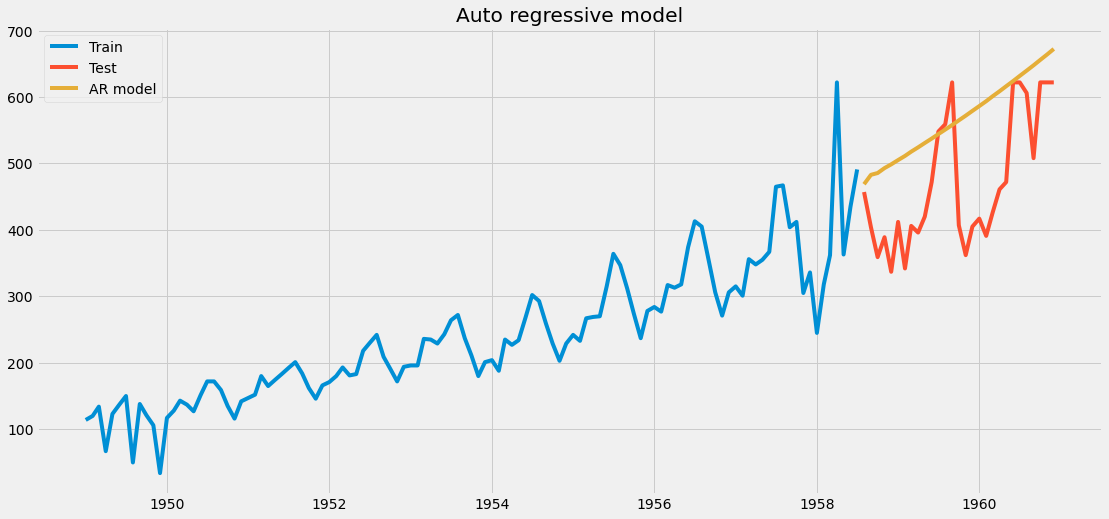

In [19]:
plt.figure(figsize=(17,8))

plt.plot(train['Customers_linear'], label = 'Train')
plt.plot(test['Customers_linear'], label = 'Test')
plt.plot(y_ar_new['ar_forecast'][test.index.min():], label = 'AR model')

plt.legend()
plt.title('Auto regressive model')
plt.show()

## 2.Moving average 移動平均 (MA)
 
在統計學中是一種通過創建整個數據集中不同子集的一系列平均數來分析數據點的計算方法。給定一個數列和一個固定子集大小，移動平均數的第一個元素是由數列的初始固定子集的平均值得到的。然後通過「向前移位」修改子集，即排除序列的第一個數，並在子集中包含下一個值。移動平均通常與時間序列數據一起使用，以消除短期波動，突出長期趨勢或周期。短期和長期之間的閾值取決於應用，移動平均的參數將相應地設置。例如，它通常用於對財務數據進行技術分析，如股票價格、收益率或交易量。它也用於經濟學中研究國內生產總值、就業或其他宏觀經濟時間序列。

數學上，移動平均是卷積的一種類型，因此它可以被看作是用於信號處理的低通濾波器的一個例子。當與非時間序列數據一起使用時，移動平均濾波器的頻率分量更高，但與時間沒有任何特定的聯繫，儘管通常暗含某種排序。簡單地看，它可以看作是把數據變得更平滑。數學方程式是：

- y(t) = µ + φ(k)*ε(t-k)
- µ 是系列的平均值
- ε(t-k) 是過去的預測值
- φ(k) 是與誤差值相關的權重

In [20]:
#from statsmodels.tsa.arima_model import ARIMA

model_ma = ARIMA(train_data_boxcox_difference, order=(0,0,7))
model_fit = model_ma.fit()
print(model_fit.params)

C:\Users\cti110016\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const      0.012553
ma.L1.y   -0.539879
ma.L2.y   -0.200034
ma.L3.y   -0.146816
ma.L4.y    0.627896
ma.L5.y   -0.310058
ma.L6.y   -0.113329
ma.L7.y   -0.317780
dtype: float64


### Recover Original Time Series

In [21]:
y_ma_new = data_boxcox_difference.copy()
y_ma_new['ma_forecast_boxcox_difference'] = model_fit.predict(data_boxcox_difference.index.min(),
                                                              data_boxcox_difference.index.max())
y_ma_new['ma_forecast_boxcox'] = y_ma_new['ma_forecast_boxcox_difference'].cumsum()
y_ma_new['ma_forecast_boxcox'] = y_ma_new['ma_forecast_boxcox'].add(data_boxcox[0])
y_ma_new['ma_forecast'] = np.exp(y_ma_new['ma_forecast_boxcox'])

### Plotting Train, Test and Forecast

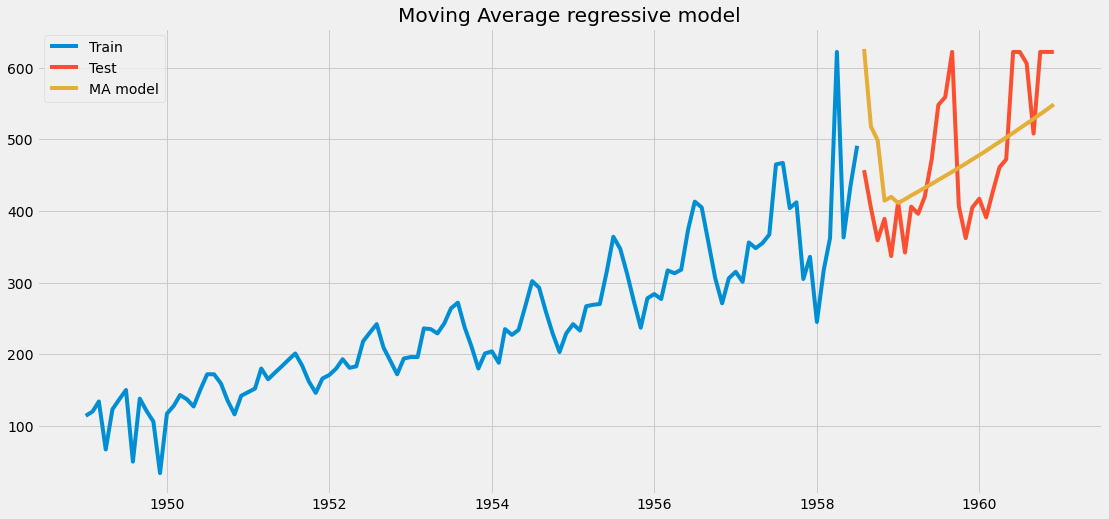

In [22]:
plt.figure(figsize=(17,8))

plt.plot(train['Customers_linear'], label = 'Train')
plt.plot(test['Customers_linear'], label = 'Test')
plt.plot(y_ma_new['ma_forecast'][test.index.min():], label = 'MA model')

plt.legend()
plt.title('Moving Average regressive model')
plt.show()

## 3. AutoRegressive Integrated Moving Average Model (ARIMA)

差分整合移動平均自迴歸模型，時間序列預測分析方法之一。ARIMA（p，d，q）中，AR是"自回歸"，p為自回歸項數；MA為"滑動平均"，q為滑動平均項數，d為使之成為平穩序列所做的差分次數（階數）。「差分」一詞雖未出現在ARIMA的英文名稱中，卻是關鍵步驟。
它使用 Box Cox 轉換時間序列，然後自己處理差異並從時間序列中刪除趨勢。我們需要使用三個參數：
- p 是模型中的最高滯後
- d 是使序列平穩的差分程度
- q 是包含的過去錯誤項的數量

In [23]:
# from statsmodels.tsa.arima_model import ARIMA

# model = ARIMA(train_data_boxcox, order=(5,1,2))
# model_fit = model.fit()
# print(model_fit.params)

### Recover Time Series Data

In [24]:
# y_arima_new = data_boxcox_difference.copy()
# y_arima_new['arima_forecast_boxcox_difference'] = model_fit.predict(data_boxcox_difference.index.min(),
#                                                                     data_boxcox_difference.index.max())
# y_arima_new['arima_forecast_boxcox'] = y_arima_new['arima_forecast_boxcox_difference'].cumsum()
# y_arima_new['arima_forecast_boxcox'] = y_arima_new['arima_forecast_boxcox'].add(data_boxcox[0])
# y_arima_new['arima_forecast'] = np.exp(y_arima_new['arima_forecast_boxcox'])

### Plotting Train, Test and Forecast

In [25]:
# plt.figure(figsize=(17,8))

# plt.plot(train['Customers_linear'], label = 'Train')
# plt.plot(test['Customers_linear'], label = 'Test')
# plt.plot(y_arima_new['arima_forecast'][test.index.min():], label = 'ARiMA model')

# plt.legend()
# plt.title('Auto regressive Integrated Moving Average model')
# plt.show()

# Seasonal AutoRegressive Integrated Moving Average Model (SARIMA)

季節性自回歸綜合移動平均模型 (SARIMA) 帶來了 ARIMA 模型的所有特徵以及季節性。在 SARIMA 中執行的關鍵元素是：
- 對時間序列進行差分以使其平穩。
- SARIMA 方程是過去觀察和過去誤差的線性組合。
- 對時間序列執行季節性差分。
- SARIMA 將未來季節性建模為過去季節性觀察結果和過去季節性誤差的線性組合。

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox_difference, order=(1,1,1), seasonal_order=(1,1,1,6))
model_fit = model.fit()
print(model_fit.params)

C:\Users\cti110016\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\cti110016\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ar.L1     -0.577562
ma.L1     -0.997883
ar.S.L6   -0.734170
ma.S.L6   -0.539953
sigma2     0.049832
dtype: float64


C:\Users\cti110016\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Recover Original Time Series Data

In [27]:
y_sarima_new = data_boxcox_difference.copy()
y_sarima_new['sarima_forecast_boxcox_difference'] = model_fit.predict(data_boxcox_difference.index.min(),
                                                                      data_boxcox_difference.index.max())
y_sarima_new['sarima_forecast_boxcox'] = y_sarima_new['sarima_forecast_boxcox_difference'].cumsum()
y_sarima_new['sarima_forecast_boxcox'] = y_sarima_new['sarima_forecast_boxcox'].add(data_boxcox[0])
y_sarima_new['sarima_forecast'] = np.exp(y_sarima_new['sarima_forecast_boxcox'])

### Plotting Train, Test and Forecasted data

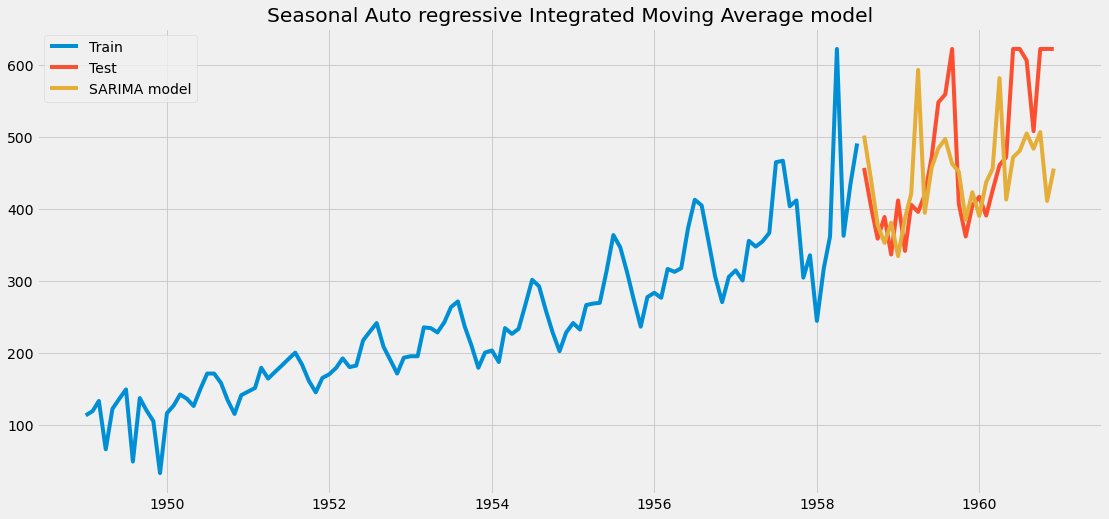

In [28]:
plt.figure(figsize=(17,8))

plt.plot(train['Customers_linear'], label = 'Train')
plt.plot(test['Customers_linear'], label = 'Test')
plt.plot(y_sarima_new['sarima_forecast'][test.index.min():], label = 'SARIMA model')

plt.legend()
plt.title('Seasonal Auto regressive Integrated Moving Average model')
plt.show()